# Problem 7.2

Attribution: Elena, Michelle, and Shashank all contributed to (a) and (b)

First we load the necessary modules.

In [110]:
import os
import warnings

# Our numerical workhorses
import numpy as np
import numdifftools as ndt
import emcee
import corner

# Image processing tools
import skimage
import skimage.io

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.filterwarnings('ignore')


# Part A

Let's load the first TIFF stack and see how many frames it contains.

In [111]:
# Load in TIFF stack
fname = './data/goehring_frap_data/PH_138_A.tif'
ic = skimage.io.ImageCollection(fname, conserve_memory=False)

# How long is it?
print('There are {0:d} frames.'.format(len(ic)))

There are 149 frames.


Now let's take a look at the frames immediately before and after the photobleaching event.

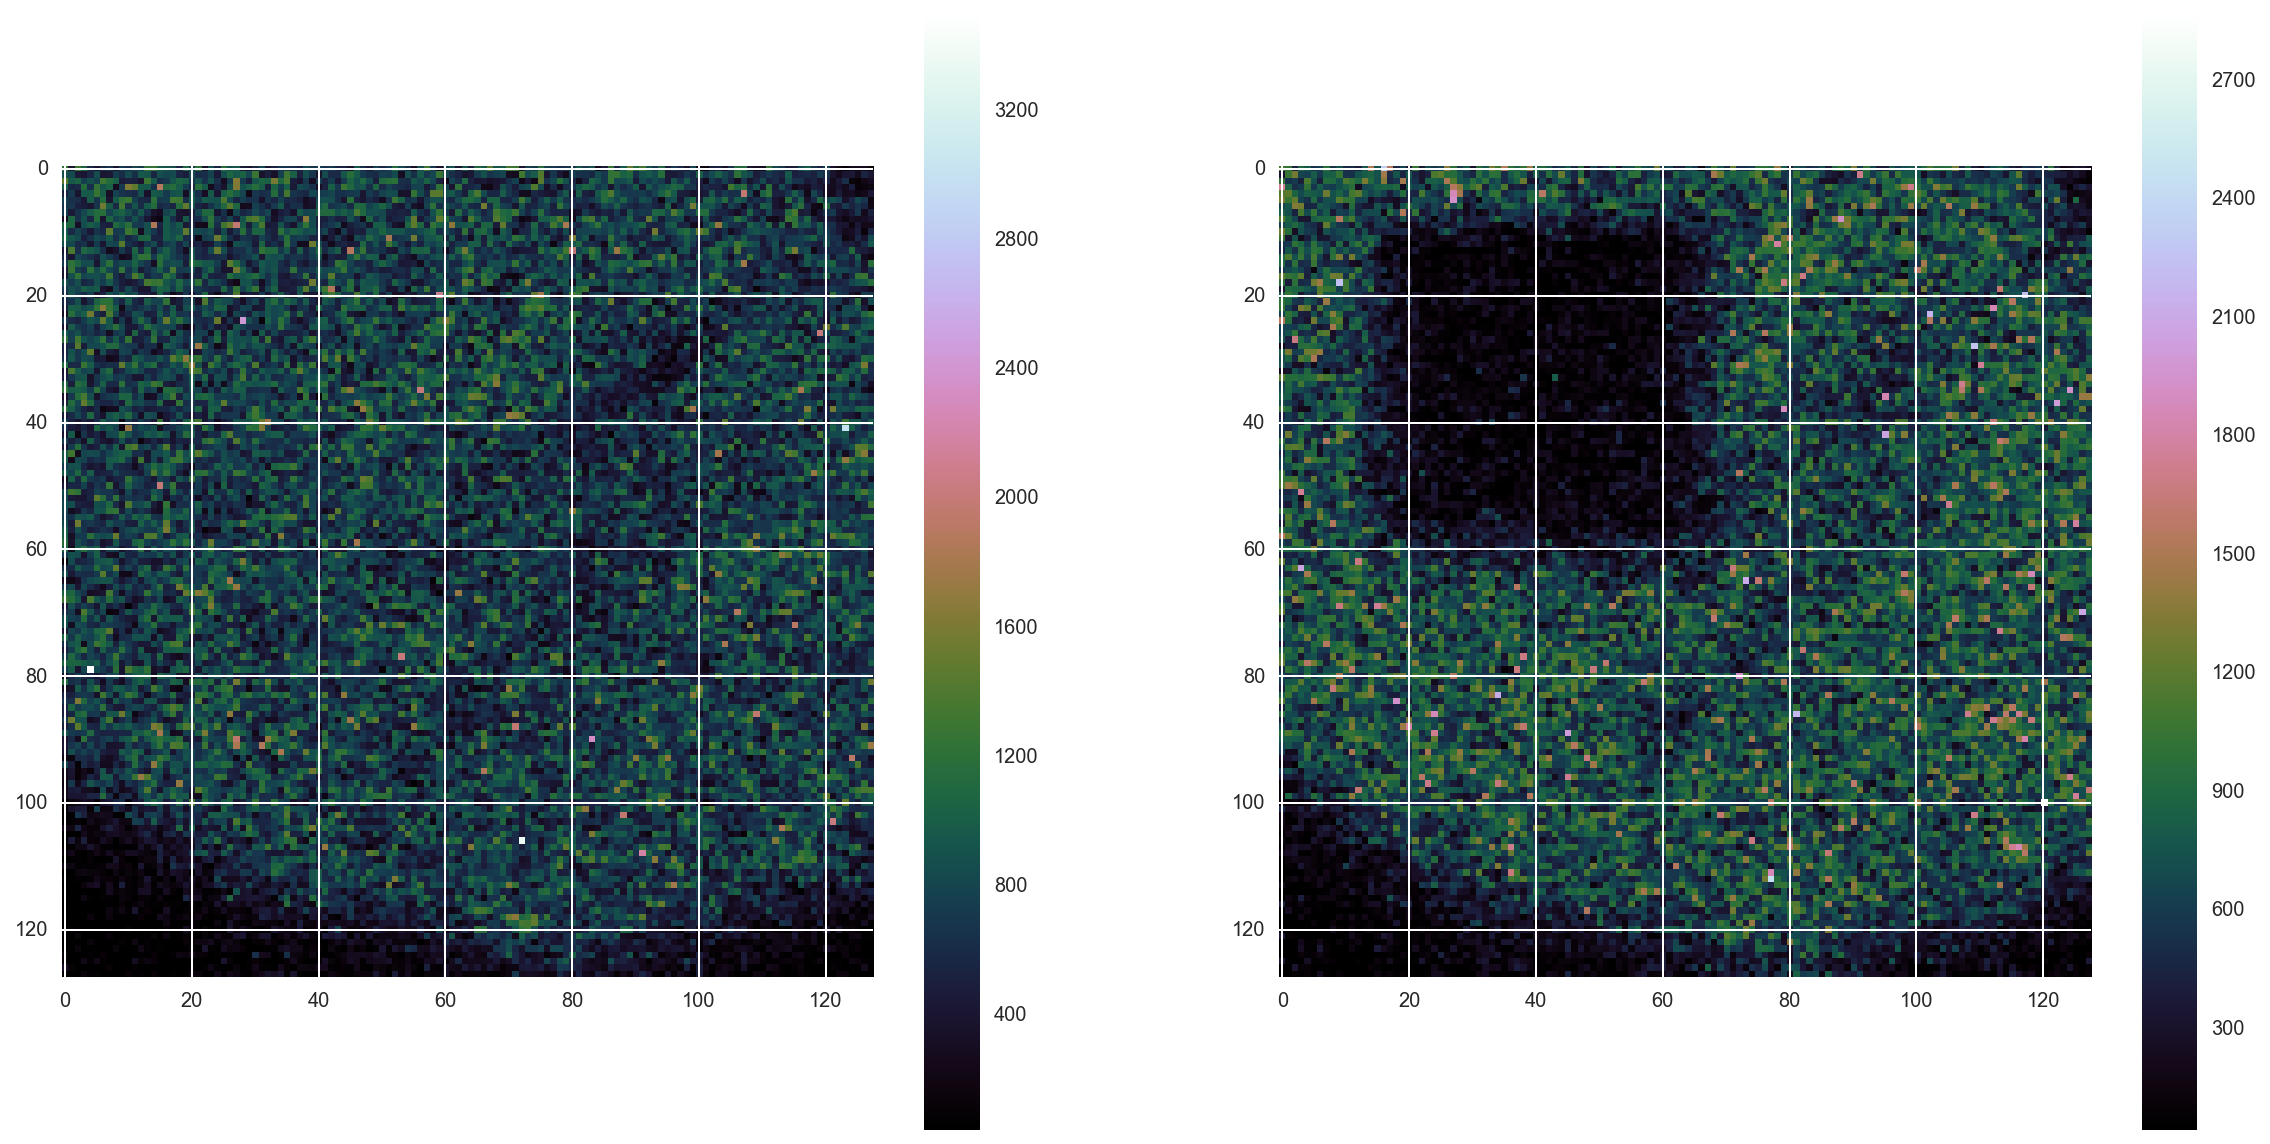

In [112]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
skimage.io.imshow(ic[19])
plt.subplot(1,2,2)
skimage.io.imshow(ic[20])

We can see that as described in the "readme" file, the photobleached area is a square of approximately 40x40 pixels.

Now let's write a function to extract the normalized mean intensity (i.e. fluorescence) versus time from each of the TIFF stacks.

In [136]:
# set up list of all the TIFF stacks so we can iterate over it
fname = ['./data/goehring_FRAP_data/PH_138_A.tif',
         './data/goehring_FRAP_data/PH_138_B.tif',
         './data/goehring_FRAP_data/PH_138_C.tif',
         './data/goehring_FRAP_data/PH_138_D.tif',
         './data/goehring_FRAP_data/PH_138_E.tif',
         './data/goehring_FRAP_data/PH_138_F.tif',
         './data/goehring_FRAP_data/PH_138_G.tif',
         './data/goehring_FRAP_data/PH_138_H.tif']

def frap_processing(fname):
    """
    Returns an array of the mean normalized intensity and an array of 
    time values (in seconds) for all files in a list of TIFF stacks. 
    t = 0 seconds is defined as the first frame after photobleaching. 
    """
    norm_intensity = np.empty((len(fname), 129))
    t_new = np.empty((len(fname), 129))
    
    for i, f in enumerate(fname):
        # load a TIFF stack
        ic = skimage.io.ImageCollection(f, conserve_memory=False)

        # find image subregion with minimum total intensity
        # define a total intensity value that all actual subregions will beat
        im = ic[20]
        min_int = im.max() * 40**2

        for j in range(im.shape[0] - 40):
            for k in range(im.shape[1] - 40):
                if im[j:j+40, k:k+40].sum() < min_int:
                    min_int = im[j:j+40, k:k+40].sum()
                    vert = (j, k)
                    
        # define ROI
        roi = np.s_[vert[0]:vert[0]+40,vert[1]:vert[1]+40]

        # set up array of time values (seconds)
        fps = 5.32
        t = np.arange(0, len(ic))/fps

        # calculate the mean intensity of the ROI for each frame
        # we treat the first frame separately because it is 3-dimensional
        intensity = np.empty(len(t))
        intensity[0] = ic[0][0,:,:][roi].mean()
        for j in range(1, len(ic)):
            intensity[j] = ic[j][roi].mean()

        # normalize intensity 
        #(intensity after photobleaching / intensity before photobleaching)
        intensity_0 = intensity[0:20].mean()
        norm_intensity[i,:] = intensity[20:]/intensity_0

        # redefine time array so that photobleaching occurs at t = 0
        t_new[i,:] = t[20:] - t[20]
        
    return t_new, norm_intensity

# now let's run the function
t, norm_intensity = frap_processing(fname)

Let's plot the normalized mean intensity vs. time for each of the experimental repeats (which we call "Trial A", "Trial B", etc.). We will only plot the data starting at t = 0 which is defined as the time of the photobleaching event.

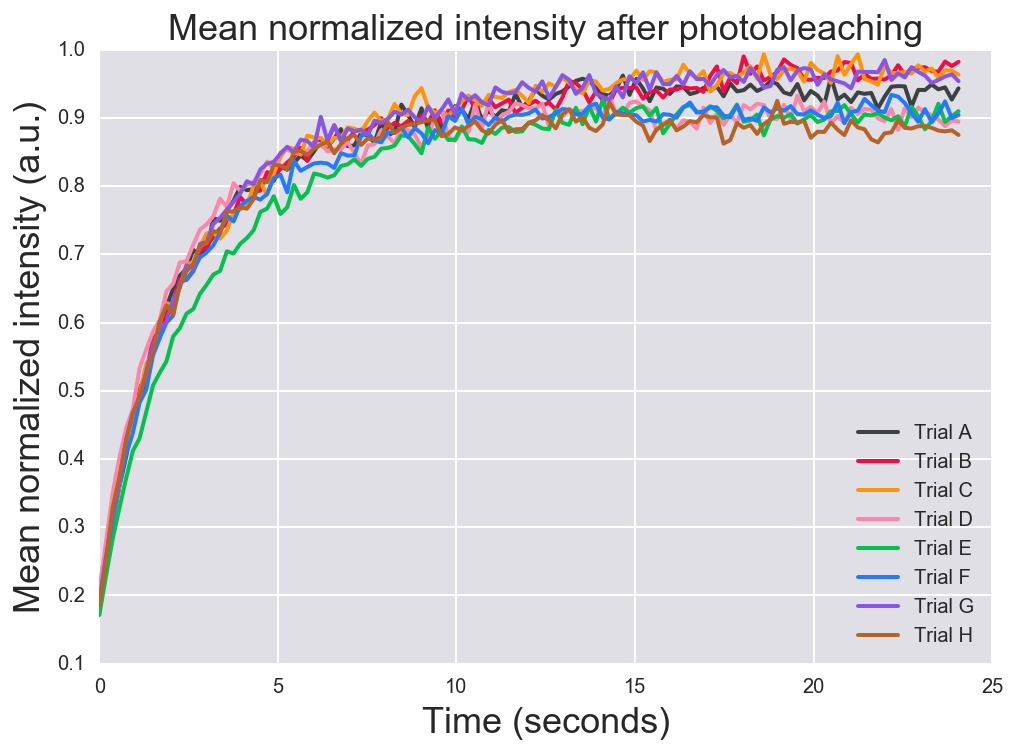

In [115]:
color_list = ['charcoal grey', 'pinkish red', 'tangerine', 'pinky',
              'shamrock green', 'clear blue', 'purpley', 'copper']
for i in range(len(t)):
    plt.plot(t[i,:], norm_intensity[i,:], color=sns.xkcd_rgb[color_list[i]])

plt.legend(['Trial A', 'Trial B', 'Trial C', 'Trial D',
            'Trial E', 'Trial F', 'Trial G', 'Trial H'], loc=4)
plt.title('Mean normalized intensity after photobleaching')
plt.xlabel('Time (seconds)')
plt.ylabel('Mean normalized intensity (a.u.)')

The plots look fairly similar, which is what you typically want to see for experimental repeats. We note that the fluorescence does not recover to 100% but rather to somewhere between approximately 90-95%. However, the deliberately photobleached square accounts for less than 5% of the membrane area, given that the C. elegans embryo is a 50 by 20 micron prolate spheroid and the photobleached square is 40x40 pixels where each pixel is 0.138 µM to a side. Thus we would naively expect >95% recovery. We think the slightly low recovery may be due to two possible factors: 1) the images are taken using lasers so there may be some additional, unintentional photobleaching over the course of each experimental repeat as a result of the imaging process, and 2) a small fraction of the photobleached molecules may be immobile.

# Part B

For the regression, we first translate the mathematical model for FRAP into a Python function.

Mathematical model for normalized intensity as a function of time after photobleaching: 

\begin{align}
I_\mathrm{norm}(t) \equiv \frac{I(t)}{I_0} &= 
f_f\left(1 - f_b\,\frac{4 \mathrm{e}^{-k_\mathrm{off}t}}{d_x d_y}\,\psi_x(t)\,\psi_y(t)\right),
\text{where }\\ & \psi_i(t) = \frac{d_i}{2}\,\mathrm{erf}\left(\frac{d_i}{\sqrt{4Dt}}\right)
-\sqrt{\frac{D t}{\pi}}\left(1 - \mathrm{e}^{-d_i^2/4Dt}\right)
\end{align}

Note: $f_b$ is the fraction of fluorophores that were bleached, $f_f$ is the fraction of fluorophores remaining, $k_{off}$ is the phenomenological rate constant for unbinding from PIP, $D$ is the diffusion coefficient for the PH-PLCd1/PIP2 complex on the membrane, and $d_x$ and $d_y$ are the extent of the photobleached box in the x- and y-directions.

In [137]:
def psi_func(d_i, D, t ):
    
    """
    Define psi function for theoretical model.
    d_i is d_x or d_y: extent of photobleached box in the x and y directions.
    D: diffusion co-efficient for PH-PLCd1/PIP2.
    t: time (s).
    """
    first_term_const = d_i/2
    
    erf_func = scipy.special.erf(d_i/np.sqrt(4*D*t))
    
    second_term_const = np.sqrt(D*t/np.pi)
    
    second_term = 1 - np.exp(-d_i**2/4/D/t)
    
    return first_term_const*erf_func - second_term_const*second_term

def theoretical_model(f_f, f_b, k_off, d_x, d_y, D, t):
    """
    Define theoretical model for normalized intensity in FRAP.
    d_x and d_y: extent of photobleached box in the x and y directions (µM)
    D: diffusion co-efficient for PH-PLCd1/PIP2 (square micrometers/second)
    t: time (s)
    k_off: rate constant for unbinding for PIP2
    f_b: fraction of fluorophores that were bleached
    f_f: fraction of fluorophores remaining
    """
    return f_f * (1 - f_b*4*np.exp(-k_off*t)/(d_x*d_y) * psi_func(d_x, D, t) * psi_func(d_y, D, t))

In [117]:
def residuals(p, t, d_x, d_y, experimental_I):
    """
    Calculate residuals.
    """
    # Unpack parameters
    D, k_off, f_b, f_f = p
    
    # Compute residuals
    return experimental_I - theoretical_model(f_f, f_b, k_off, d_x, d_y, D, t)

def log_likelihood(p, t, d_x, d_y, experimental_I):
    """
    Log likelihood based on Student t distribution.
    """
    #unpack parameters
    D, k_off, f_b, f_f = p
    
    theoretical_I = theoretical_model(f_f, f_b, k_off, d_x, d_y, D, t)
    
    return -len(t) / 2 * np.log(np.sum(residuals(p, t, d_x, d_y, experimental_I)**2))
    
def log_prior(p):
    """
    Log prior. We take uniform priors for f_b, f_f,
    and Jeffreys priors for D, k_off.
    """
    #unpack parameters
    D, k_off, f_b, f_f = p
    
    if f_f <= 0 or f_f >= 1 or f_b <= 0 or f_b >= 1 or D <= 0 or k_off <= 0:   
        return -np.inf
    
    return -np.log(D) - np.log(k_off)

def log_post(p, t, d_x, d_y, experimental_I):
    """
    Log posterior.
    """    
    lp = log_prior(p)
    
    if lp == -np.inf:
        return -np.inf
    
    return log_likelihood(p, t, d_x, d_y, experimental_I) + log_prior(p)

Once we are done defining our likelihood, prior and posterior distributions, we define a  function that will perform MCMC to perform regression for each FRAP trial. We also tried optimization (`scipy.optimize.leastsq`) which gave us the same parameter estimates, but we decided to stick with MCMC for this analysis.

We will be estimating the value for four parameters: the physical parameters of interest ($D$, and $k_{off}$), and $f_b$, and $f_f$, the fraction of molecules that were bleached and the fraction of fluorescent molecules that were left.

In [118]:
def frap_mcmc(t, norm_intensity, n_dim=4, n_walkers=100, n_burn=1000, n_steps=10000):
    """
    Run MCMC to perform regression for each FRAP trial.
    Takes in the outputs from frap_processing function.
    """
    
    D_MAP_arr = np.empty(len(t))
    k_off_MAP_arr = np.empty(len(t))
    f_b_MAP_arr = np.empty(len(t))
    f_f_MAP_arr = np.empty(len(t))
    flatchain_arr = np.empty((len(t), n_steps * n_walkers, n_dim))
    
    # define d_x and d_y in µM
    d_x, d_y = 40 * 0.138, 40 * 0.138 

    for i in range(len(t)):
        # arguments to pass to log posterior function
        args = (t[i], d_x, d_y, norm_intensity[i])

        p0 = np.empty((n_walkers, n_dim))
        p0[:,0] = np.random.exponential(1, n_walkers) # D
        p0[:,1] = np.random.exponential(1, n_walkers) # k_off
        p0[:,2] = np.random.uniform(0, 1, n_walkers) # f_b
        p0[:,3] = np.random.uniform(0, 1, n_walkers) # f_f

        sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post, args=args)

        pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

        _ = sampler.run_mcmc(pos, n_steps)

        max_ind = np.argmax(sampler.flatlnprobability)

        # Pull out values.
        D_MAP, k_off_MAP, f_b_MAP, f_f_MAP = sampler.flatchain[max_ind,:]

        D_MAP_arr[i] = D_MAP
        k_off_MAP_arr[i] = k_off_MAP
        f_b_MAP_arr[i] = f_b_MAP
        f_f_MAP_arr[i] = f_f_MAP
        flatchain_arr[i,:,:] = sampler.flatchain

    return D_MAP_arr, k_off_MAP_arr, f_b_MAP_arr, f_f_MAP_arr, flatchain_arr

Let's get the *maximum a posteriori* estimates for each of our parameters, and plot the corner plot to look at the distribution for the first trial.

In [50]:
D_MAP_arr, k_off_MAP_arr, f_b_MAP_arr, f_f_MAP_arr, flatchain_arr = frap_mcmc(t, norm_intensity)

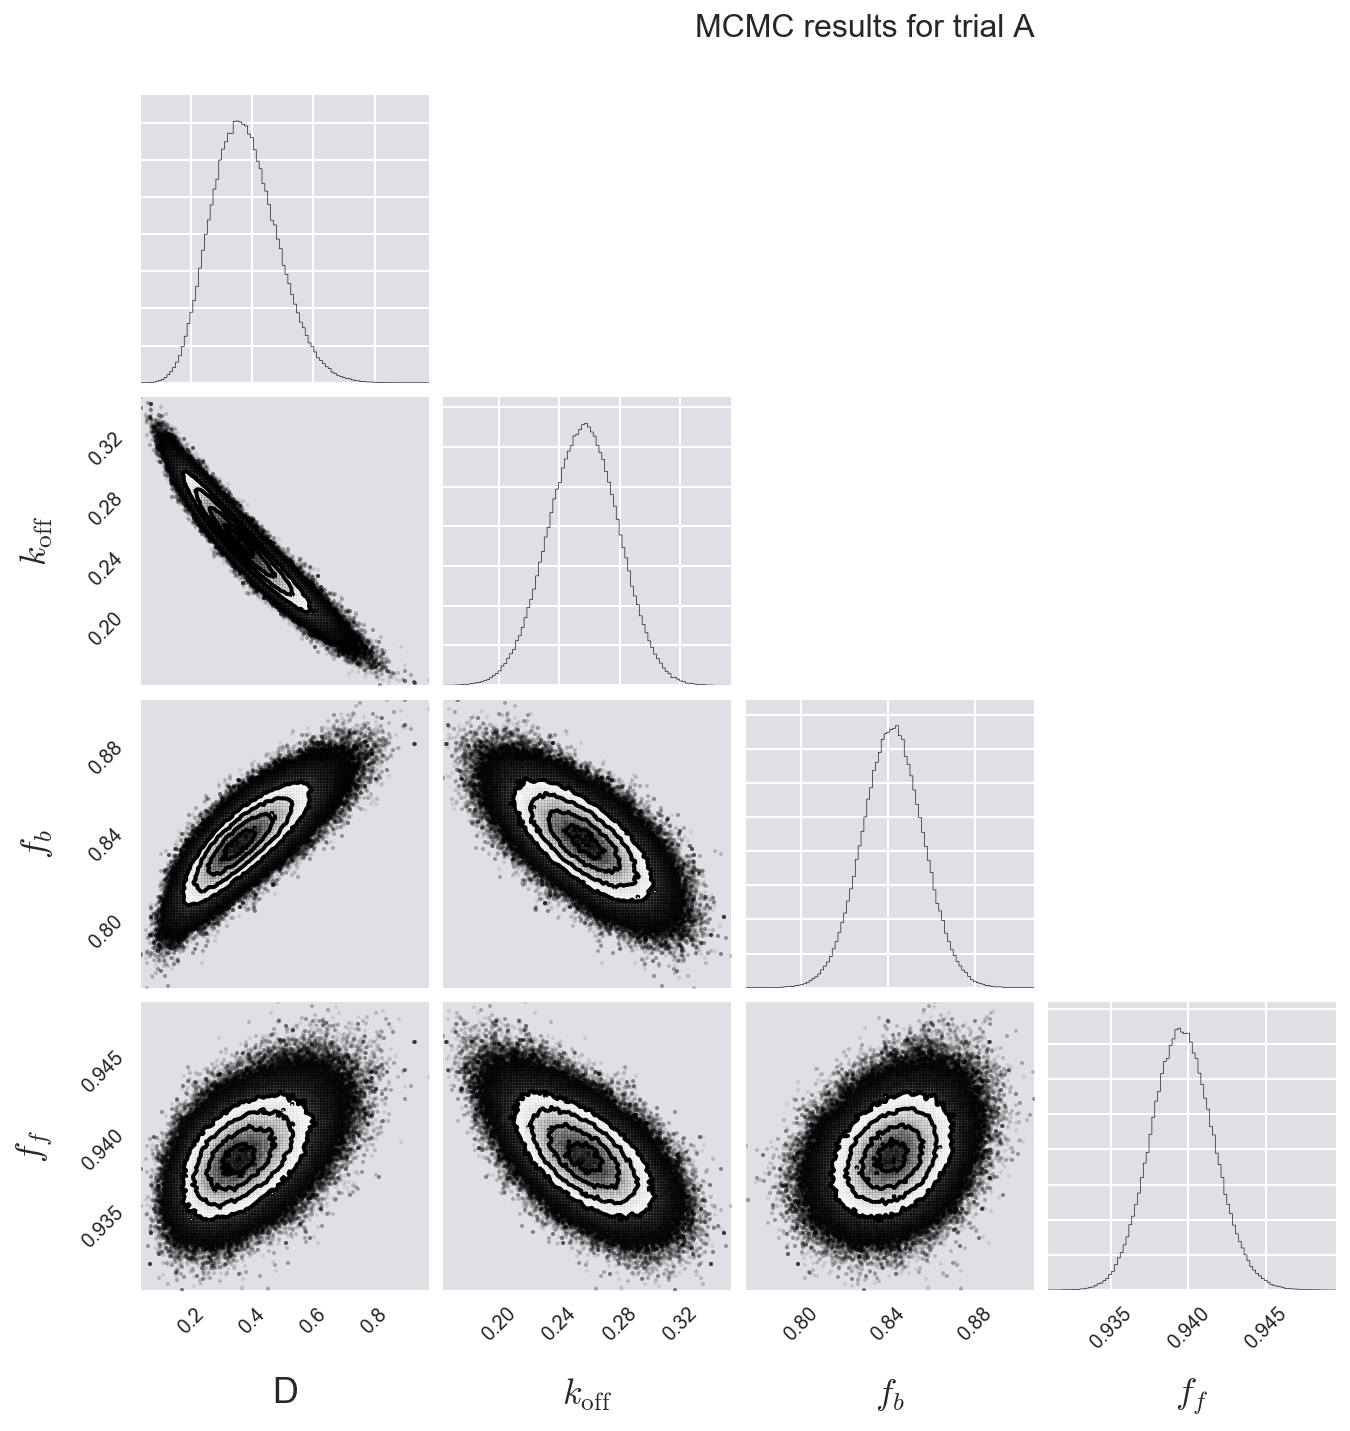

In [53]:
fig = corner.corner(flatchain_arr[0], labels=['D', r'$k_\mathrm{off}$', r'$f_b$', r'$f_f$'], bins=100)
fig.text(0.5, 1, 'MCMC results for trial A', fontsize=16)

The corner plot looks pretty good, with sharp unimodal posterior distrubutions for all the parameters. Here we are just using the corner plot as a sort of sanity check to make sure that the posteriors look reasonable, and since they do for the first trial, we will omit them for the other trials (we did check them quickly but are omitting them to save you some scrolling). Now, let's calculate the error bars for each parameter and report the parameter estimations for all of the trials.

In [70]:
# Print the results
print("""
Most probable parameter values for trial A:
D:  {0:.3f} ± {1:.3f} square micrometers/second
k_off: {2:.3f} ± {3:.3f} 
f_b: {4:.3f} ± {5:.3f}
f_f: {6:.3f} ± {7:.3f}""".format(D_MAP_arr[0], flatchain_arr[0,:,0].std(),
           k_off_MAP_arr[0], flatchain_arr[0,:,1].std(),
           f_b_MAP_arr[0], flatchain_arr[0,:,2].std(),
           f_f_MAP_arr[0], flatchain_arr[0,:,3].std()))

# Print the results
print("""
Most probable parameter values for trial B:
D:  {0:.3f} ± {1:.3f} square micrometers/second
k_off: {2:.3f} ± {3:.3f} 
f_b: {4:.3f} ± {5:.3f}
f_f: {6:.3f} ± {7:.3f}""".format(D_MAP_arr[1], flatchain_arr[1,:,0].std(),
           k_off_MAP_arr[1], flatchain_arr[1,:,1].std(),
           f_b_MAP_arr[1], flatchain_arr[1,:,2].std(),
           f_f_MAP_arr[1], flatchain_arr[1,:,3].std()))

# Print the results
print("""
Most probable parameter values for trial C:
D:  {0:.3f} ± {1:.3f} square micrometers/second
k_off: {2:.3f} ± {3:.3f} 
f_b: {4:.3f} ± {5:.3f}
f_f: {6:.3f} ± {7:.3f}""".format(D_MAP_arr[2], flatchain_arr[2,:,0].std(),
           k_off_MAP_arr[2], flatchain_arr[2,:,1].std(),
           f_b_MAP_arr[2], flatchain_arr[2,:,2].std(),
           f_f_MAP_arr[2], flatchain_arr[2,:,3].std()))

# Print the results
print("""
Most probable parameter values for trial D:
D:  {0:.3f} ± {1:.3f} square micrometers/second
k_off: {2:.3f} ± {3:.3f} 
f_b: {4:.3f} ± {5:.3f}
f_f: {6:.3f} ± {7:.3f}""".format(D_MAP_arr[3], flatchain_arr[3,:,0].std(),
           k_off_MAP_arr[3], flatchain_arr[3,:,1].std(),
           f_b_MAP_arr[3], flatchain_arr[3,:,2].std(),
           f_f_MAP_arr[3], flatchain_arr[3,:,3].std()))

# Print the results
print("""
Most probable parameter values for trial E:
D:  {0:.3f} ± {1:.3f} square micrometers/second
k_off: {2:.3f} ± {3:.3f} 
f_b: {4:.3f} ± {5:.3f}
f_f: {6:.3f} ± {7:.3f}""".format(D_MAP_arr[4], flatchain_arr[4,:,0].std(),
           k_off_MAP_arr[4], flatchain_arr[4,:,1].std(),
           f_b_MAP_arr[4], flatchain_arr[4,:,2].std(),
           f_f_MAP_arr[4], flatchain_arr[4,:,3].std()))

# Print the results
print("""
Most probable parameter values for trial F:
D:  {0:.3f} ± {1:.3f} square micrometers/second
k_off: {2:.3f} ± {3:.3f} 
f_b: {4:.3f} ± {5:.3f}
f_f: {6:.3f} ± {7:.3f}""".format(D_MAP_arr[5], flatchain_arr[5,:,0].std(),
           k_off_MAP_arr[5], flatchain_arr[5,:,1].std(),
           f_b_MAP_arr[5], flatchain_arr[5,:,2].std(),
           f_f_MAP_arr[5], flatchain_arr[5,:,3].std()))

# Print the results
print("""
Most probable parameter values for trial G:
D:  {0:.3f} ± {1:.3f} square micrometers/second
k_off: {2:.3f} ± {3:.3f} 
f_b: {4:.3f} ± {5:.3f}
f_f: {6:.3f} ± {7:.3f}""".format(D_MAP_arr[6], flatchain_arr[6,:,0].std(),
           k_off_MAP_arr[6], flatchain_arr[6,:,1].std(),
           f_b_MAP_arr[6], flatchain_arr[6,:,2].std(),
           f_f_MAP_arr[6], flatchain_arr[6,:,3].std()))

# Print the results
print("""
Most probable parameter values for trial G:
D:  {0} ± {1:.3f} square micrometers/second
k_off: {2:.3f} ± {3:.3f} 
f_b: {4:.3f} ± {5:.3f}
f_f: {6:.3f} ± {7:.3f}""".format(D_MAP_arr[7], flatchain_arr[7,:,0].std(),
           k_off_MAP_arr[7], flatchain_arr[7,:,1].std(),
           f_b_MAP_arr[7], flatchain_arr[7,:,2].std(),
           f_f_MAP_arr[7], flatchain_arr[7,:,3].std()))


Most probable parameter values for trial A:
D:  0.354 ± 0.106 square micrometers/second
k_off: 0.259 ± 0.023 
f_b: 0.840 ± 0.014
f_f: 0.939 ± 0.002

Most probable parameter values for trial B:
D:  0.851 ± 0.137 square micrometers/second
k_off: 0.129 ± 0.032 
f_b: 0.866 ± 0.014
f_f: 0.967 ± 0.004

Most probable parameter values for trial C:
D:  0.592 ± 0.098 square micrometers/second
k_off: 0.181 ± 0.018 
f_b: 0.859 ± 0.012
f_f: 0.968 ± 0.002

Most probable parameter values for trial D:
D:  0.181 ± 0.102 square micrometers/second
k_off: 0.374 ± 0.030 
f_b: 0.780 ± 0.015
f_f: 0.904 ± 0.002

Most probable parameter values for trial E:
D:  0.108 ± 0.041 square micrometers/second
k_off: 0.279 ± 0.013 
f_b: 0.820 ± 0.010
f_f: 0.906 ± 0.001

Most probable parameter values for trial F:
D:  0.172 ± 0.056 square micrometers/second
k_off: 0.314 ± 0.016 
f_b: 0.808 ± 0.010
f_f: 0.910 ± 0.001

Most probable parameter values for trial G:
D:  0.357 ± 0.096 square micrometers/second
k_off: 0.240 ± 0.

We can also plot the data for each trial overlaid with the theoretical models using the parameter estimates from MCMC. 

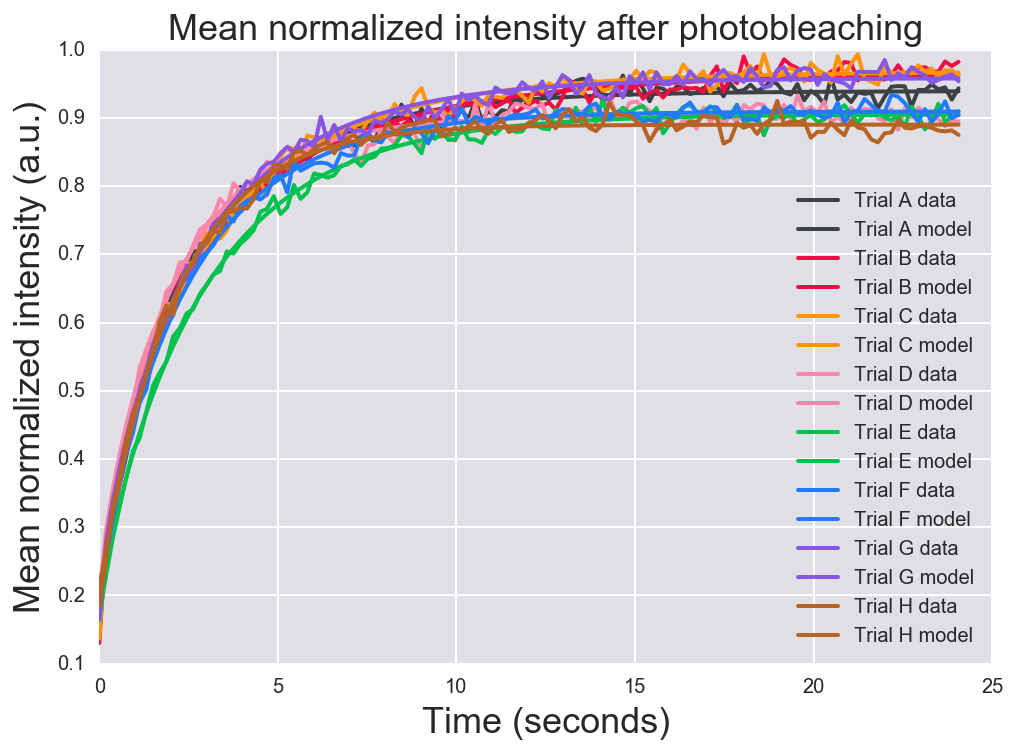

In [109]:
p_arr = np.array([D_MAP_arr, k_off_MAP_arr, f_b_MAP_arr, f_f_MAP_arr])

for i in range(len(t)):
    D, k_off, f_b, f_f = p_arr[:,i]
    plt.plot(t[i], norm_intensity[i], color=sns.xkcd_rgb[color_list[i]])
    plt.plot(t[i], theoretical_model(f_f, f_b, k_off, d_x, d_y, D, t[i]), color=sns.xkcd_rgb[color_list[i]])

plt.legend(['Trial A data', 'Trial A model', 'Trial B data', 'Trial B model',
            'Trial C data', 'Trial C model', 'Trial D data', 'Trial D model',
            'Trial E data', 'Trial E model', 'Trial F data', 'Trial F model',
            'Trial G data', 'Trial G model', 'Trial H data', 'Trial H model'], loc=4)
plt.title('Mean normalized intensity after photobleaching')
plt.xlabel('Time (seconds)')
plt.ylabel('Mean normalized intensity (a.u.)')

The regression curves look like they fit the data reasonably well. 

We also made a box plot of the estimates for each of the theoretical model parameters.

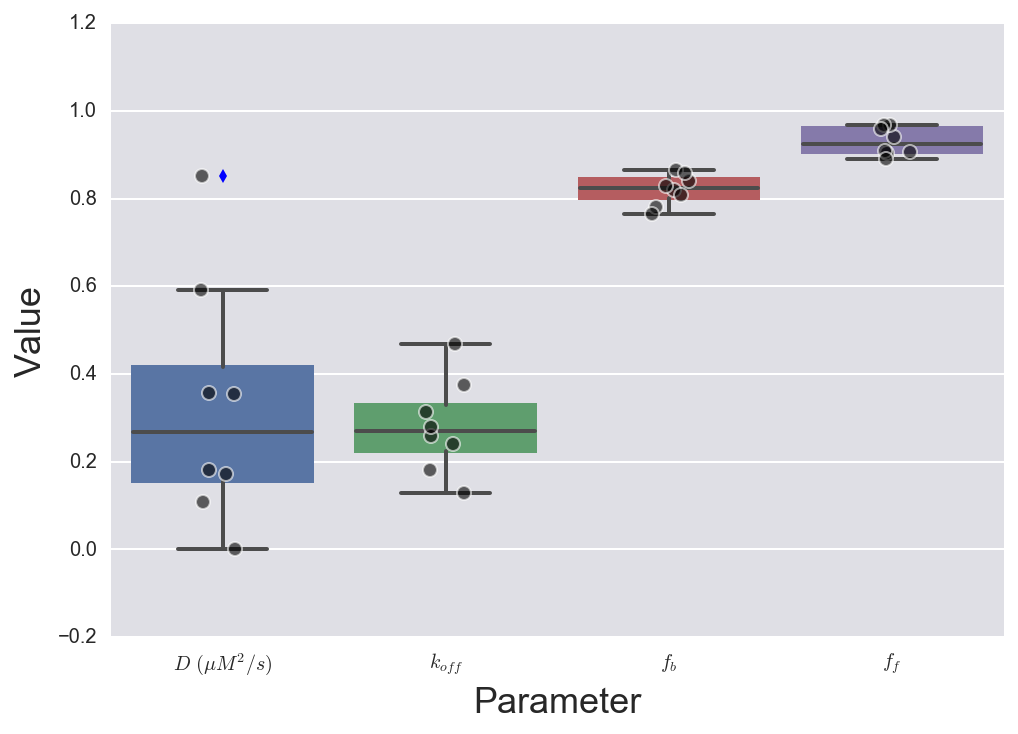

In [138]:
df_maps = pd.DataFrame(columns=['Parameter', 'Value'])
d_list = [r'$D \,\,(\mu M^2/s)$'] * 8
k_off_list = [r'$k_{off}$'] * 8
f_b_list = [r'$f_b$'] * 8
f_f_list = [r'$f_f$'] * 8
params_list = d_list + k_off_list + f_b_list + f_f_list
df_maps['Parameter'] = params_list
df_maps['Value'] = np.concatenate((D_MAP_arr, k_off_MAP_arr, f_b_MAP_arr, f_f_MAP_arr))

ax = sns.boxplot(x=df_maps['Parameter'], y=df_maps['Value'])
ax  = sns.stripplot(x=df_maps['Parameter'], 
                    y=df_maps['Value'], 
                    data=df_maps, 
                    jitter=True, 
                    alpha=0.6,
                    color='black')

There are a couple of observations that seem very interesting. Firstly, the medians for $D$ and $k_{off}$ seem to be the same. This suggests that both the diffusion coefficient for the PH-PLCd1/PIP2 complex on the membrane, $D$, and the phenomenological rate constant for unbinding of PIP2 on the membrane, $k_{off}$, are necessary to explain the process of fluorescence recovery.

Another interesting observation is the *maximum a posteriori* estimate for $f_f$, the fraction of fluorescent species left after photo-bleaching. As can be seen from the strip-plot, the approximate value of $f_f$ is ~ 90%. This means that following photobleaching, even though the PH-PLCd1 molecules diffuse into the bleached region, the molecules are unable to recover the fluorescence of that particular region back to 100%. This is defined as percent recovery, and between different trials, the MAP value varies from ~89% to ~96%. This is all in line with what we observed in part (a), and our proposed explanations from part (a) still hold.
